In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-11-23 15:16:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.128, 74.125.26.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-11-23 15:16:11 (169 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [27]:
import json
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

In [18]:
with open("/tmp/sarcasm.json", "r") as f:
    datastore = json.load(f)

sentences = []
labels = []
for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])

In [32]:
vocab_size = 1000
embedding_dim = 8
max_length = 150
trunc_type = "post"
padding_type = "post"
oov_token = "<OOV>"
training_size = 20000

In [33]:
x_train = np.array(sentences[:training_size])
y_train = np.array(labels[:training_size])

x_test = np.array(sentences[training_size:])
y_test = np.array(labels[training_size:])

In [34]:
print(len(y_test)/len(sentences))

0.2511887378786177


In [35]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

seq_train = tokenizer.texts_to_sequences(x_train)
pad_train = pad_sequences(seq_train, maxlen=max_length, padding=padding_type,
                         truncating=trunc_type)

seq_test = tokenizer.texts_to_sequences(x_test)
pad_test = pad_sequences(seq_test, maxlen=max_length, padding=padding_type,
                         truncating=trunc_type)


In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [37]:
num_epochs = 30

In [38]:
history = model.fit(pad_train, y_train, epochs=num_epochs,
         validation_data=(pad_test, y_test), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.6843 - accuracy: 0.5596 - val_loss: 0.6774 - val_accuracy: 0.5633
Epoch 2/30
625/625 - 2s - loss: 0.6427 - accuracy: 0.6245 - val_loss: 0.5859 - val_accuracy: 0.7298
Epoch 3/30
625/625 - 2s - loss: 0.5204 - accuracy: 0.7678 - val_loss: 0.4787 - val_accuracy: 0.7778
Epoch 4/30
625/625 - 2s - loss: 0.4402 - accuracy: 0.8022 - val_loss: 0.4387 - val_accuracy: 0.7977
Epoch 5/30
625/625 - 2s - loss: 0.4094 - accuracy: 0.8151 - val_loss: 0.4214 - val_accuracy: 0.8056
Epoch 6/30
625/625 - 2s - loss: 0.3931 - accuracy: 0.8216 - val_loss: 0.4190 - val_accuracy: 0.8032
Epoch 7/30
625/625 - 2s - loss: 0.3834 - accuracy: 0.8256 - val_loss: 0.4117 - val_accuracy: 0.8086
Epoch 8/30
625/625 - 2s - loss: 0.3766 - accuracy: 0.8289 - val_loss: 0.4099 - val_accuracy: 0.8089
Epoch 9/30
625/625 - 2s - loss: 0.3708 - accuracy: 0.8306 - val_loss: 0.4037 - val_accuracy: 0.8119
Epoch 10/30
625/625 - 2s - loss: 0.3660 - accuracy: 0.8355 - val_loss: 0.4017 - val_accuracy: 0.8128

In [39]:
def plot_history(history, string):
    
    plt.plot(history.history[string])
    plt.plot(history.history[f"val_{string}"])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, f"val_{string}"])
    plt.show()
    
    

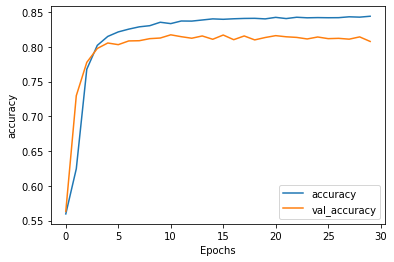

In [40]:
plot_history(history, "accuracy")

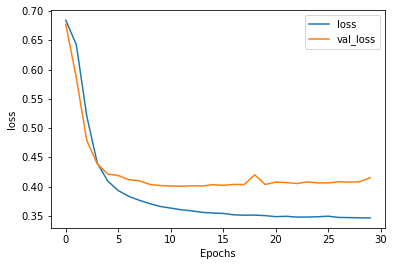

In [41]:
plot_history(history, "loss")

In [45]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(pad_train[2]))
print(x_train[2])
print(labels[2])

mom starting to fear <OOV> <OOV> series <OOV> thing she will have to <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [46]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 8)


In [47]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))